In [1]:
!pip install simpy

In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

In [3]:
def hospital_simulation(arrival_rate, service_time, num_doctors):

    env = simpy.Environment()
    doctor = simpy.Resource(env, capacity=num_doctors)
    waiting_times = []

    def patient(env):
        arrival_time = env.now

        with doctor.request() as request:
            yield request
            wait = env.now - arrival_time
            waiting_times.append(wait)
            yield env.timeout(service_time)

    def patient_arrivals(env):
        while env.now < 480:  # simulate 8 hours (480 minutes)
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(patient(env))

    env.process(patient_arrivals(env))
    env.run()

    if len(waiting_times) == 0:
        return 0

    return np.mean(waiting_times)

| Parameter         | Lower Bound | Upper Bound | Reason                 |
| ----------------- | ----------- | ----------- | ---------------------- |
| Arrival Rate      | 0.05        | 0.5         | 3–30 patients/hour     |
| Service Time      | 5           | 20 minutes  | realistic consultation |
| Number of Doctors | 1           | 5           | small hospital setup   |


In [4]:
data = []

for _ in range(1000):

    arrival_rate = random.uniform(0.05, 0.5)
    service_time = random.uniform(5, 20)
    num_doctors = random.randint(1, 5)

    avg_wait = hospital_simulation(arrival_rate, service_time, num_doctors)

    data.append([arrival_rate, service_time, num_doctors, avg_wait])

df = pd.DataFrame(data, columns=[
    "arrival_rate",
    "service_time",
    "num_doctors",
    "avg_wait_time"
])

df.head()

,arrival_rate,service_time,num_doctors,avg_wait_time
0,0.483861,17.947377,2,784.395896
1,0.304407,17.808522,3,180.550256
2,0.359882,18.679416,3,292.856050
3,0.454714,11.105930,5,13.400729
4,0.429645,19.444431,4,239.568397


In [5]:
X = df.drop("avg_wait_time", axis=1)
y = df["avg_wait_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(results, columns=[
    "Model", "MAE", "RMSE", "R2 Score"
])

results_df.sort_values(by="R2 Score", ascending=False)

,Model,MAE,RMSE,R2 Score
2,Random Forest,27.514156,53.507398,0.967517
3,Gradient Boosting,37.200713,61.013673,0.957764
1,Decision Tree,33.549355,66.109862,0.950414
4,AdaBoost,107.007962,124.594419,0.823873
6,KNN,87.526584,158.331142,0.715579
0,Linear Regression,151.747072,195.089811,0.568185
5,SVR,151.090872,306.007762,-0.062414


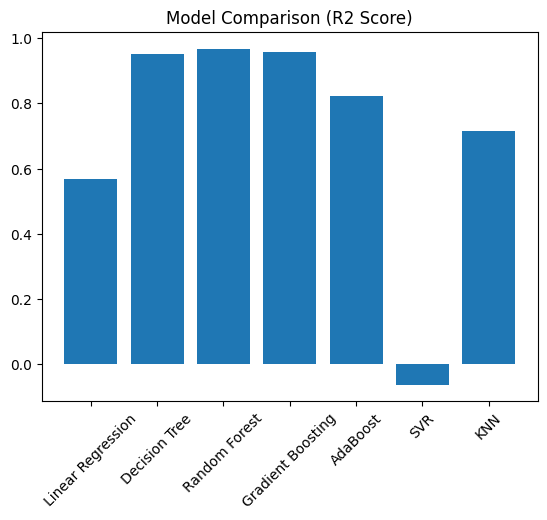

In [7]:
plt.figure()
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xticks(rotation=45)
plt.title("Model Comparison (R2 Score)")
plt.show()

In [8]:
best_model = results_df.sort_values(by="R2 Score", ascending=False).iloc[0]
best_model

,2
Model,Random Forest
MAE,27.514156
RMSE,53.507398
R2 Score,0.967517
